# Capstone project

---

Car accident model - based on Data from the UK Department for Transport (2005-2014)

Data files provide detailed road safety data about the circumstances of personal injury road accidents in GB from 2005 to 2014:

- Accident file: main data set contains information about accident severity, weather, location, date, hour, day of week, road type…
- Vehicle file: contains information about vehicle type, vehicle model, engine size, driver sex, driver age, car age…
- Casualty file: contains information about casualty severity, age, sex social class, casualty type, pedestrian or car passenger…

---

# Introduction

Unfortunately, car accidents happen.

Would it be possible to understand/predict the severity of an eventual accident if ever happening?

Such a predictive model could be interesting for instance:

- For insurance companies to set a final price for an inssurance.
- For government authorities to forcast casualties that may occur during a year based on vehicles registered and drivers records an plan measures to reduce those casualties numbers.
- For generate awareness in individuals so that they are aware of the need of replacing their car, be even more careful when it rains or when it's a foggy day, etc.

We will be exploring the feasibility of creating such a predictive model based on variables that could be stored into the following catergories:

- Driver data (age, etc.)
- Time, road and environmental conditions (visibility, weather conditions, moment of the year, etc.)
- Car specifications (Engine capacity, driver side, etc)
- Parameters of the accident (speed, point of impact, etc.)

Based on those variables the model would predict if ever having an accident if it's going to be "fatal", "Serious" or "Slight" a certain probability (multiclass classification problem). We could also for simplicity, make the model to assist a binary classification model where based on the same variables we would be looking to predict between "fatal accidents" and "serious/slight" accidents.

To proceed we will be using the database published on Kaggle.com called "UK Accidents 10 years history with many variables" that collects accidents that took place from 2005-2014 in UK roads. Data are stored in 3 tables: accidents, vehicles and casualties and can be found in the following link: https://www.kaggle.com/benoit72/uk-accidents-10-years-history-with-many-variables

NOTE: this database is likely to give insights / prediction model to be used only for countries like UK, Japan, Australia, India (more that 50 countries) where traffic happens from left side.

---


### 0. Loading data and packages

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install scikit-learn
print('Scikit-learn lib Installed!')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import svm

# Loading data for each .csv data file available and dropping columns that wouldn't 
# look as adequate or specially relevant to build a model.

df_accidents = pd.read_csv('Accidents0514.csv')

atrib_to_drop_df_accidents = ['Location_Easting_OSGR','Location_Northing_OSGR','Longitude','Latitude',
                             'Police_Force','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities',
                             'Special_Conditions_at_Site','Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident','LSOA_of_Accident_Location',
                             '1st_Road_Class','1st_Road_Number','Junction_Detail','Junction_Control','2nd_Road_Class','2nd_Road_Number',
                             'Number_of_Vehicles','Local_Authority_(District)','Local_Authority_(Highway)','Road_Type','Time','Number_of_Casualties',
                             'Weather_Conditions']

df_accidents.drop(columns = atrib_to_drop_df_accidents, inplace=True)

df_vehicles = pd.read_csv('Vehicles0514.csv')

atrib_to_drop_df_vehicles = ['Towing_and_Articulation','Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane','Junction_Location',
                            'Skidding_and_Overturning','Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway','Hit_Object_off_Carriageway',
                            'Driver_IMD_Decile','Driver_Home_Area_Type','Vehicle_Reference','Was_Vehicle_Left_Hand_Drive?','Journey_Purpose_of_Driver',
                            'Age_of_Driver','Propulsion_Code','Engine_Capacity_(CC)']

df_vehicles.drop(columns = atrib_to_drop_df_vehicles, inplace=True)

df_casualties = pd.read_csv('Casualties0514.csv')

atrib_to_drop_df_casualties = ['Casualty_Reference','Sex_of_Casualty','Age_of_Casualty','Age_Band_of_Casualty',
                               'Pedestrian_Location','Pedestrian_Movement','Bus_or_Coach_Passenger','Pedestrian_Road_Maintenance_Worker',
                               'Casualty_Home_Area_Type','Vehicle_Reference','Casualty_Class','Car_Passenger','Casualty_Type']

df_casualties.drop(columns = atrib_to_drop_df_casualties, inplace=True)

Scikit-learn lib Installed!


C:\Users\Sergio\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1. Data wrangling

In [105]:
# We join dataframes based on key column Accident_Index
df = df_vehicles.join(df_casualties.set_index('Accident_Index'), on='Accident_Index')
df = df.join(df_accidents.set_index('Accident_Index'), on='Accident_Index')

# After joining the tables, Accident_Index can be drop now
df.drop(columns = 'Accident_Index', inplace=True)
print('Shape after join of tables and drop of a priori no needed variables :', df.shape)

# According to the data 
df = df.replace(-1,np.NaN)
print(df.isna().sum())
df.dropna(axis=0,inplace=True)
print('Shape after drop of rows contaning NaN values:', df.shape)

# In case some rows would be duplicated we remove them
df_cars.drop_duplicates()
print('Shape after drop of duplicated: ', df.shape)

# We want to check at this point the distribution of the Accident_Severity in our dataset
print('Distribution of Accident_Severity after join tables: ',df['Accident_Severity'].value_counts())

Shape after join of tables and drop of a priori no needed variables : (4287593, 13)
Vehicle_Type                   554
1st_Point_of_Impact           2418
Sex_of_Driver                   46
Age_Band_of_Driver          405664
Age_of_Vehicle             1155488
Casualty_Severity                0
Accident_Severity                0
Date                             0
Day_of_Week                      0
Speed_limit                      0
Light_Conditions                 0
Road_Surface_Conditions       4824
Urban_or_Rural_Area              0
dtype: int64
Shape after drop of rows contaning NaN values: (2944421, 13)
Shape after drop of duplicated:  (2944421, 13)
Distribution of Accident_Severity after join tables:  3    2469760
2     413143
1      61518
Name: Accident_Severity, dtype: int64


We will develop the model only for cars, therefore in the dataset we will only conserve events related to car accidents.

In [106]:
# In the data we have information for different kinds of vehicles, keeping only data for cares stored in value = 9
print(df['Vehicle_Type'].value_counts())

# Only taking car, value = 9 according to tables
df_cars = df.loc[df['Vehicle_Type'] == 9]
df_cars.drop(columns = 'Vehicle_Type', inplace=True)
print(df_cars.shape)

9.0     2399925
19.0     134424
5.0       82233
11.0      80927
8.0       55046
21.0      54278
3.0       53692
2.0       29212
4.0       21050
20.0      14939
10.0       6756
90.0       6651
17.0       5002
98.0        149
97.0        120
22.0         11
23.0          6
Name: Vehicle_Type, dtype: int64
(2399925, 12)


C:\Users\Sergio\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We have Accident_Severity (from Accidents table) and Casualty_Severity (from Casualties table), that seem to be the same. However after testing, we see they are different.
In order to keep data that are reliable, we remove any row where Accident_Severity and Casualty_Severity value would be different.
Afterwards, we will drop the column Casualty_Severity.

In [107]:
# Accident_Severity and Casualty_Severity should be equal, checking to see if we can remove one of the columns
print(df_cars['Accident_Severity'].equals(df_cars['Casualty_Severity']))

# Accident_Severity and Casualty_Severity are not equal according to analysis, therefore need to remove those rows do not have equal values for those columns
df_cars.drop(df_cars.index[df_cars['Accident_Severity'] != df_cars['Casualty_Severity']], inplace = True)
df_cars.drop(columns = ['Casualty_Severity'], inplace=True)
print(df_cars['Accident_Severity'].value_counts())

print(df_cars.shape)
df_cars.head()

False
3    2049825
2     123561
1       8337
Name: Accident_Severity, dtype: int64
(2181723, 11)


,1st_Point_of_Impact,Sex_of_Driver,Age_Band_of_Driver,Age_of_Vehicle,Accident_Severity,Date,Day_of_Week,Speed_limit,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
3,3.0,1.0,9.0,6.0,3,06/01/2005,5,30,4,1.0,1
4,1.0,2.0,8.0,4.0,3,07/01/2005,6,30,1,1.0,1
6,0.0,1.0,8.0,1.0,3,11/01/2005,3,30,1,2.0,1
9,2.0,1.0,7.0,4.0,3,13/01/2005,5,30,4,1.0,1
10,1.0,1.0,10.0,16.0,3,14/01/2005,6,30,1,1.0,1


In [108]:
# Arranging the order of the columns in the df_cars so that is easier to understand
df_cars = df_cars[['Age_Band_of_Driver','Sex_of_Driver',
                   'Age_of_Vehicle','Light_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area',
                   '1st_Point_of_Impact','Speed_limit',
                   'Date','Day_of_Week',
                   'Accident_Severity']]

In [109]:
# Reseting indexes and visualizing final df_cars
df_cars.reset_index(drop=True).head()

# We save the final dataset cars.csv
df_cars.to_csv('carsFinal.csv',index=False)

### 2. Data Analysis

In [110]:
# Visualizing df_cars after data cleaning and wrangling
df_cars = pd.read_csv('carsFinal.csv')
df_cars.head()

,Age_Band_of_Driver,Sex_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,1st_Point_of_Impact,Speed_limit,Date,Day_of_Week,Accident_Severity
0,9.0,1.0,6.0,4,1.0,1,3.0,30,06/01/2005,5,3
1,8.0,2.0,4.0,1,1.0,1,1.0,30,07/01/2005,6,3
2,8.0,1.0,1.0,1,2.0,1,0.0,30,11/01/2005,3,3
3,7.0,1.0,4.0,4,1.0,1,2.0,30,13/01/2005,5,3
4,10.0,1.0,16.0,1,1.0,1,1.0,30,14/01/2005,6,3


In [111]:
# We see now how preselected variables correlate with Accident_Severity
df_cars.corr()

,Age_Band_of_Driver,Sex_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,1st_Point_of_Impact,Speed_limit,Day_of_Week,Accident_Severity
Age_Band_of_Driver,1.000000,-0.031775,-0.079929,-0.128581,-0.046625,0.018128,0.030858,-0.001292,0.001000,-0.025657
Sex_of_Driver,-0.031775,1.000000,-0.068730,-0.087021,0.000412,-0.014493,0.024161,-0.031721,-0.001025,0.032874
Age_of_Vehicle,-0.079929,-0.068730,1.000000,0.031899,0.014168,-0.016714,-0.030055,-0.041266,-0.000407,-0.012945
Light_Conditions,-0.128581,-0.087021,0.031899,1.000000,0.181736,0.055506,-0.022521,0.078464,0.004963,-0.049134
Road_Surface_Conditions,-0.046625,0.000412,0.014168,0.181736,1.000000,0.105173,-0.037506,0.100130,-0.009341,0.009354
Urban_or_Rural_Area,0.018128,-0.014493,-0.016714,0.055506,0.105173,1.000000,-0.057966,0.670915,-0.011380,-0.021701
1st_Point_of_Impact,0.030858,0.024161,-0.030055,-0.022521,-0.037506,-0.057966,1.000000,-0.048705,-0.000545,0.000141
Speed_limit,-0.001292,-0.031721,-0.041266,0.078464,0.100130,0.670915,-0.048705,1.000000,-0.008853,-0.008108
Day_of_Week,0.001000,-0.001025,-0.000407,0.004963,-0.009341,-0.011380,-0.000545,-0.008853,1.000000,0.001642
Accident_Severity,-0.025657,0.032874,-0.012945,-0.049134,0.009354,-0.021701,0.000141,-0.008108,0.001642,1.000000


Let's analyze data type and change it if needed

We need now to analyze the selected variables vs Accident_Severity to decide thresholding and improve categorization of the data

#### 2.0. Accident Severity

In [112]:
# We verify the distribution we have for Accident_Severity
print(df_cars['Accident_Severity'].value_counts())

3    2049825
2     123561
1       8337
Name: Accident_Severity, dtype: int64


#### 2.1. Age Band of Driver

In [113]:
x = df_cars['Accident_Severity'].values
y = df_cars['Age_Band_of_Driver'].values

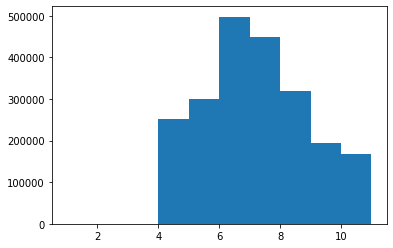

In [114]:
# Distribution of ages is more or less homogeneous 
plt.hist(df_cars['Age_Band_of_Driver']);

In [115]:
print(df_cars.groupby(['Accident_Severity','Age_Band_of_Driver']).size())

values_ageDriver = df_cars.groupby(['Accident_Severity','Age_Band_of_Driver']).size().to_numpy()
values_ageDriver

Accident_Severity  Age_Band_of_Driver
1                  3.0                       14
                   4.0                      987
                   5.0                     1242
                   6.0                     1690
                   7.0                     1386
                   8.0                     1146
                   9.0                      789
                   10.0                     545
                   11.0                     538
2                  2.0                        3
                   3.0                       47
                   4.0                    13422
                   5.0                    16673
                   6.0                    25632
                   7.0                    23432
                   8.0                    18492
                   9.0                    12588
                   10.0                    7429
                   11.0                    5843
3                  1.0                        3
  

array([    14,    987,   1242,   1690,   1386,   1146,    789,    545,
          538,      3,     47,  13422,  16673,  25632,  23432,  18492,
        12588,   7429,   5843,      3,      7,    436, 237597, 283164,
       470767, 424337, 298728, 180925,  95063,  58798], dtype=int64)

In [116]:
df_cars['Age_Band_of_Driver'].replace({1:0 , 2:0 , 3:0, 4:1, 5:1, 6:2, 7:2, 8:2, 9:2, 10:3, 11:3}, inplace=True)

#### 2.2. Sex of Driver

In [117]:
# Removing data values in this column that are set as not specified = 3
df_cars.drop(df_cars.loc[df_cars['Sex_of_Driver']==3].index, inplace=True)
print(df_cars.shape)

(2176452, 11)


In [118]:
df_cars['Sex_of_Driver'].value_counts()

1.0    1296549
2.0     879903
Name: Sex_of_Driver, dtype: int64

In [119]:
df_cars.groupby(['Accident_Severity','Sex_of_Driver']).size()

Accident_Severity  Sex_of_Driver
1                  1.0                 6263
                   2.0                 2051
2                  1.0                80229
                   2.0                42892
3                  1.0              1210057
                   2.0               834960
dtype: int64

#### 2.3. Age of Vehicle

(array([1.801437e+06, 3.699350e+05, 4.413000e+03, 4.430000e+02,
        1.390000e+02, 2.900000e+01, 2.200000e+01, 2.200000e+01,
        8.000000e+00, 4.000000e+00]),
 array([  1.,  12.,  23.,  34.,  45.,  56.,  67.,  78.,  89., 100., 111.]),
 <a list of 10 Patch objects>)

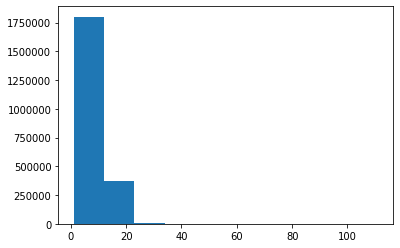

In [120]:
plt.hist(df_cars['Age_of_Vehicle'])

(2175493, 11)


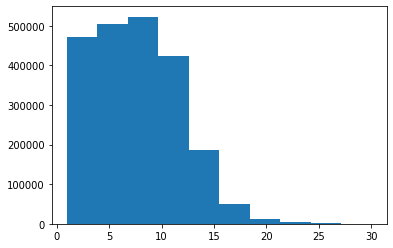

In [121]:
# Keeping cars that are with an age below 30 (based on fq distribution, most data of the dataset will be conserved)
df_cars.drop(df_cars.loc[df_cars['Age_of_Vehicle'] > 30].index, inplace=True)
print(df_cars.shape)

plt.hist(df_cars['Age_of_Vehicle'])

df_cars['Age_of_Vehicle'].value_counts()

df_cars.groupby(['Accident_Severity','Age_of_Vehicle']).size()

df_cars['Age_of_Vehicle'].replace({1:0 , 2:0 , 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0,
                                 11:0, 12:0, 13:0, 14:0, 15:0, 16:1, 17:1, 18:1, 19:1, 20:1,
                                  21:1, 22:1, 23:1, 24:1, 25:1, 26:1, 27:1, 28:1, 29:1, 30:1}, inplace=True)

#### 2.4. Light Conditions

Accident_Severity  Light_Conditions
1                  0                      3994
                   1                      4311
2                  0                     39365
                   1                     83651
3                  0                    527231
                   1                   1516941
dtype: int64


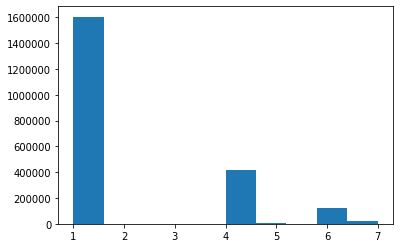

In [122]:
plt.hist(df_cars['Light_Conditions'])

# if 0 there is some kind of darkness situation, if 1 daylight
df_cars['Light_Conditions'].replace({1:1 , 4:0 , 5:0, 6:0, 7:0}, inplace=True)

print(df_cars.groupby(['Accident_Severity','Light_Conditions']).size())

#### 2.5. Road Surface Conditions

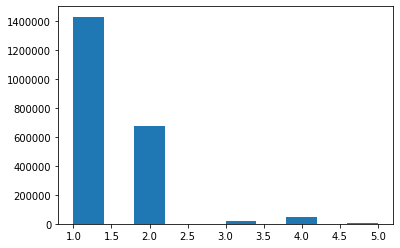

In [123]:
plt.hist(df_cars['Road_Surface_Conditions'])

# We set new categories (simplified) => 1 = dry , 2 = wet / ice / snow related
df_cars['Road_Surface_Conditions'].replace({1:1 , 2:2 , 3:2, 4:2, 5:2}, inplace=True)

In [124]:
print(df_cars.groupby(['Accident_Severity','Road_Surface_Conditions']).size())

Accident_Severity  Road_Surface_Conditions
1                  1.0                           5320
                   2.0                           2985
2                  1.0                          83731
                   2.0                          39285
3                  1.0                        1341752
                   2.0                         702420
dtype: int64


#### 2.6. Urban or rural area

In [125]:
df_cars['Urban_or_Rural_Area'].value_counts()

1    1285856
2     889506
3        131
Name: Urban_or_Rural_Area, dtype: int64

We will group big cities accidents in 0 and the rest small cities and rural in 1

In [126]:
df_cars['Urban_or_Rural_Area'].replace({1:0 , 2:1, 3:1}, inplace=True)

print(df_cars.groupby(['Accident_Severity','Urban_or_Rural_Area']).size())

Accident_Severity  Urban_or_Rural_Area
1                  0                         3140
                   1                         5165
2                  0                        70179
                   1                        52837
3                  0                      1212537
                   1                       831635
dtype: int64


#### 2.7. First point of impact

1.0    1081815
2.0     511180
3.0     285266
4.0     233807
0.0      63425
Name: 1st_Point_of_Impact, dtype: int64
Accident_Severity  1st_Point_of_Impact
1                  0.0                        706
                   1.0                       7599
2                  0.0                       5867
                   1.0                     117149
3                  0.0                      56852
                   1.0                    1987320
dtype: int64


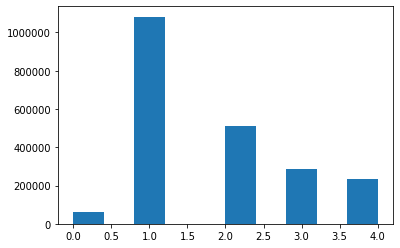

In [127]:
plt.hist(df_cars['1st_Point_of_Impact'])

print(df_cars['1st_Point_of_Impact'].value_counts())

df_cars['1st_Point_of_Impact'].replace({0:0, 1:1 , 2:1, 3:1, 4:1}, inplace=True)

print(df_cars.groupby(['Accident_Severity','1st_Point_of_Impact']).size())

#### 2.8. Speed limit

Accident_Severity  Speed_limit
1                  10                   1
                   20                  39
                   30                2921
                   40                 838
                   50                 394
                   60                2966
                   70                1146
2                  20                1281
                   30               71006
                   40               10415
                   50                4573
                   60               27679
                   70                8062
3                  10                   6
                   15                  14
                   20               14153
                   30             1167391
                   40              207618
                   50               87072
                   60              346905
                   70              221013
dtype: int64
Accident_Severity  Speed_limit
1                  0                 2961
 

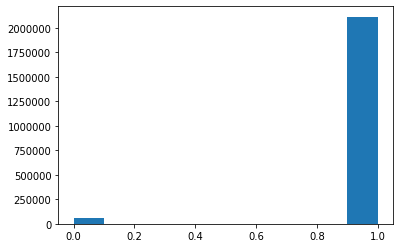

In [128]:
plt.hist(df_cars['1st_Point_of_Impact'])

print(df_cars.groupby(['Accident_Severity','Speed_limit']).size())

df_cars['Speed_limit'].replace({10:0, 15:0 , 20:0, 30:0, 40:1, 50:1, 60:1, 70:1}, inplace=True)

print(df_cars.groupby(['Accident_Severity','Speed_limit']).size())

#### 2.9. Date: month and day of the week

In [129]:
# Date is object, we make it datetime object in order to later extract month
df_cars['Date']= pd.to_datetime(df_cars['Date'])

# Extracting month from Date
df_cars['Month'] = df_cars['Date'].dt.month

# Droping Date now
df_cars.drop(columns = ['Date'], inplace=True)

In [130]:
df_cars['Month'].value_counts()

11    192563
10    190137
1     187532
5     185563
7     184811
8     183607
9     181405
6     181226
3     176013
12    175225
4     175078
2     162333
Name: Month, dtype: int64

In [131]:
df_cars.groupby(['Accident_Severity','Month']).size()

Accident_Severity  Month
1                  1           737
                   2           651
                   3           667
                   4           604
                   5           655
                   6           603
                   7           710
                   8           658
                   9           716
                   10          783
                   11          757
                   12          764
2                  1         10571
                   2          9026
                   3          9911
                   4          9800
                   5         10377
                   6         10461
                   7         10447
                   8         10132
                   9         10800
                   10        11071
                   11        10759
                   12         9661
3                  1        176224
                   2        152656
                   3        165435
                   4        16

In [132]:
df_cars['Month'].replace({1:1 , 2:1 , 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1}, inplace=True)

In [133]:
df_cars['Day_of_Week'].value_counts()

6    359496
4    316770
5    315498
3    311974
7    310497
2    300094
1    261164
Name: Day_of_Week, dtype: int64

In [134]:
df_cars.groupby(['Accident_Severity','Day_of_Week']).size()

Accident_Severity  Day_of_Week
1                  1                1364
                   2                 999
                   3                1011
                   4                1074
                   5                1071
                   6                1290
                   7                1496
2                  1               15649
                   2               16611
                   3               17641
                   4               17466
                   5               18040
                   6               19648
                   7               17961
3                  1              244151
                   2              282484
                   3              293322
                   4              298230
                   5              296387
                   6              338558
                   7              291040
dtype: int64

In [135]:
df_cars['Day_of_Week'].replace({1:0 , 2:1 , 3:1, 4:1, 5:1, 6:0, 7:0}, inplace=True)

We replace data type as needed

In [136]:
# We see the types of data we have and later replace data type accordingly if needed
print(df_cars.dtypes)

Age_Band_of_Driver         float64
Sex_of_Driver              float64
Age_of_Vehicle             float64
Light_Conditions             int64
Road_Surface_Conditions    float64
Urban_or_Rural_Area          int64
1st_Point_of_Impact        float64
Speed_limit                  int64
Day_of_Week                  int64
Accident_Severity            int64
Month                        int64
dtype: object


In [137]:
# We replace data type float for int, NOTE: Date column is a date object and will be treated differently
# df_cars.dropna(axis=0,inplace=True)
# df_cars = df_cars.astype({'Age_Band_of_Driver': int, 
#                          'Sex_of_Driver': int,
#                          'Age_of_Vehicle': int,
#                          'Road_Surface_Conditions ': int,
#                          '1st_Point_of_Impact': int})
#
# We see afterwards the data types
# print(df_cars.dtypes)

In [138]:
# Arranging the order of the columns in the df_cars so that is easier to understand
df_cars = df_cars[['Age_Band_of_Driver','Sex_of_Driver',
                   'Age_of_Vehicle','Light_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area',
                   '1st_Point_of_Impact','Speed_limit',
                   'Month','Day_of_Week',
                   'Accident_Severity']]

In [139]:
# We check now correlation values with Accident_Severity
df_cars.corr()

,Age_Band_of_Driver,Sex_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,1st_Point_of_Impact,Speed_limit,Month,Day_of_Week,Accident_Severity
Age_Band_of_Driver,1.000000,-0.021988,0.004660,0.126930,-0.049387,-0.000425,-0.006667,-0.009943,0.001764,0.030579,-0.017810
Sex_of_Driver,-0.021988,1.000000,-0.048495,0.093003,-0.002358,-0.012132,0.014114,-0.021257,0.003490,0.058250,0.034136
Age_of_Vehicle,0.004660,-0.048495,1.000000,-0.003253,0.001452,0.010751,-0.000424,0.001532,-0.006427,-0.003207,-0.011055
Light_Conditions,0.126930,0.093003,-0.003253,1.000000,-0.192313,0.024554,0.004130,0.004395,0.040828,0.039396,0.043102
Road_Surface_Conditions,-0.049387,-0.002358,0.001452,-0.192313,1.000000,0.090240,0.008867,0.087783,-0.051678,0.015660,0.009458
Urban_or_Rural_Area,-0.000425,-0.012132,0.010751,0.024554,0.090240,1.000000,-0.017646,0.637425,0.000764,-0.018527,-0.021808
1st_Point_of_Impact,-0.006667,0.014114,-0.000424,0.004130,0.008867,-0.017646,1.000000,-0.010120,-0.001119,0.004295,0.033690
Speed_limit,-0.009943,-0.021257,0.001532,0.004395,0.087783,0.637425,-0.010120,1.000000,-0.000783,-0.015356,-0.008781
Month,0.001764,0.003490,-0.006427,0.040828,-0.051678,0.000764,-0.001119,-0.000783,1.000000,-0.007175,-0.002714
Day_of_Week,0.030579,0.058250,-0.003207,0.039396,0.015660,-0.018527,0.004295,-0.015356,-0.007175,1.000000,0.006410


### 3. Modeling

### 3.1. Logistic regression

#### 3.1.1. Logistic regression: with all values

If we take all the values we will get a model that is good to predict low severity accidents BUT will not predict other scenarios:

[[0.0000e+00 2.5640e+03]
 [1.0000e+00 3.6914e+04]
 [2.0000e+00 6.1317e+05]]
Logistic regression f1_score:  0.3229374207034503
Logistic Regression Accuracy:  0.9395110381093636


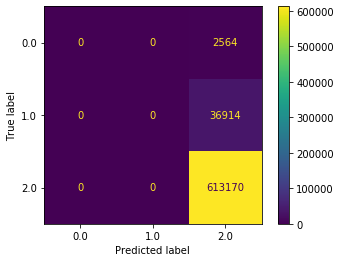

In [140]:
df_cars['Accident_Severity'].replace({1:0 , 2:1 , 3:2}, inplace=True)

# We prepare X and y
cars = df_cars.values
n,m = cars.shape

X = cars[:,0:m-1]
y = cars[:,m-1]

# We normalize X
X = StandardScaler().fit(X).transform(X)

# We make a partition of the X and y data, to have training and test data --> we use 20% of the data for test purposes and we take them randomly with shuffle = True
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)

# Let's verify that in the training set we have variety of data between 0 (fatal) and 2 (low severity)
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

# We create the logistic regression model for this multiclass case, and we train it 
clf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs').fit(X, y)

# We use the model to calculate the y_hat values
y_hat = clf.predict(X_test)
y_hat

# We calculate metrics: f1_score and accuracy:
print("Logistic regression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_hat))

# We display the confusion matrix for visibility:
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

#### 3.1.2. Logistic regression and decision tree: taking equilibrated subset of data

logisticRegression f1_score:  0.35222825995759877
logisticRegression Accuracy:  0.4175368139223561


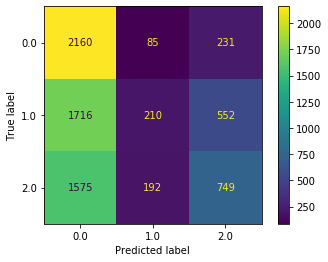

In [141]:
# We now just take a subset of the data so that we have now equilibrated amount of severity accidents between 0, 1 and 2
a = df_cars.loc[df_cars['Accident_Severity'] == 0]
b = df_cars.loc[df_cars['Accident_Severity'] == 1]
c = df_cars.loc[df_cars['Accident_Severity'] == 2]

a = a.sample(n = 8300)
b = b.sample(n = 8300)
c = c.sample(n = 8300)

new_cars = np.concatenate([a,b,c],axis=0)
n,m = new_cars.shape
X = new_cars[:,0:m-1]
y = new_cars[:,m-1]

# Logistic Regression
# We create the logistic regression model for this multiclass case, and we train it 
# We use the model to calculate the y_hat values
# We calculate metrics: f1_score
X = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)
clf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', class_weight={0:2,1:1,2:1}).fit(X, y)
y_hat = clf.predict(X_test)
print("logisticRegression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))

cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

#### 3.1.3. Logistic regression binarizing the Accident_Severity

1    2167188
0       8305
Name: Accident_Severity, dtype: int64
logisticRegression f1_score:  0.6626299116181824
logisticRegression Accuracy:  0.6626506024096386
crossValidationScore:  [0.65341525 0.65769022 0.66491957]


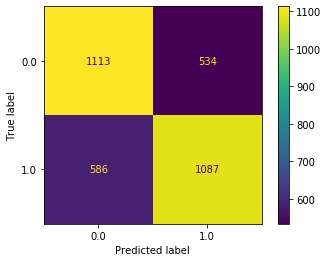

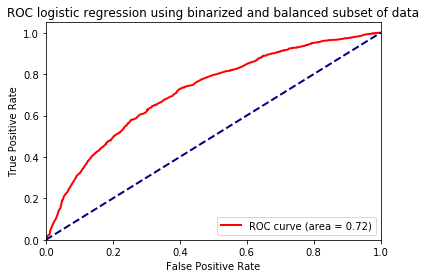

In [142]:
# We binarize Accident_Severity: fatal = 0, severe & slight = 1
df_cars['Accident_Severity'].replace({0:0 , 1:1 , 2:1}, inplace=True)
print(df_cars['Accident_Severity'].value_counts())

a = df_cars.loc[df_cars['Accident_Severity'] == 0]
b = df_cars.loc[df_cars['Accident_Severity'] == 1]

a = a.sample(n = 8300)
b = b.sample(n = 8300)

new_cars = np.concatenate([a,b],axis=0)
n,m = new_cars.shape
X = new_cars[:,1:m-1]
y = new_cars[:,m-1]
X = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)
clf = LogisticRegression(solver='lbfgs').fit(X, y)
y_hat = clf.predict(X_test)

print("logisticRegression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))
print("crossValidationScore: ", cross_val_score(clf, X, y, cv=3))

# Confusion matrix visualuzation
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

# y_hat_prob = clf.predict_proba(X_test)

# Learn to predict each class against the other
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve, ROC area and plot
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC logistic regression using binarized and balanced subset of data')
plt.legend(loc="lower right")
plt.show()

Note that, in general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

### 3.3. Decision tree

DecisionTrees's f1_score:  0.6626299116181824
DecisionTrees's Accuracy:  0.6626506024096386


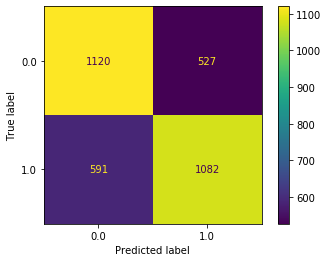

0.6757741347905283
0.6497310221159593


In [143]:
# Decision tree
DT = tree.DecisionTreeClassifier(criterion="entropy")
DT = clf.fit(X_train,y_train)
print("DecisionTrees's f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("DecisionTrees's Accuracy: ", accuracy_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(DT, X_test, y_test)
plt.show()
cmfor0 = cm[0,0]/np.sum(cm[0,]); print(cmfor0)
cmfor1 = cm[1,1]/np.sum(cm[1,]); print(cmfor1)

### 3.4. Support Vector Machine (SVM)

SVM's f1_score:  0.6646224497547675
SVM's Accuracy:  0.6647590361445783


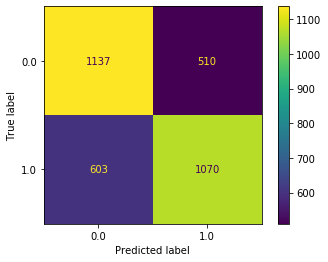

In [144]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print("SVM's f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("SVM's Accuracy: ", accuracy_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()